In [2]:
%pip install sqlite_vec

from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()  # take environment variables from .env.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


True

In [3]:

from openai import OpenAI
import sqlite3
import os

def get_db_path() -> str:
    return './covas_mining.db'

def get_connection() -> sqlite3.Connection:
    conn = sqlite3.connect(get_db_path(), detect_types=sqlite3.PARSE_DECLTYPES |
                                                        sqlite3.PARSE_COLNAMES)
    return conn

conn = get_connection()


In [ ]:
import json
import sys
from datetime import datetime
entries = conn.execute('''
select data, created_at from reply_logger_v1 ORDER BY created_at ASC
'''.replace('\n',' ')).fetchall()


for index, (entry,created_at) in enumerate(entries):
    entry = json.loads(entry)
    
    (screenshot, created_at) = conn.execute('''
    select data, created_at from screen_logger_v1 WHERE created_at >= ? ORDER BY created_at ASC LIMIT 1
    '''.replace('\n',' '), (datetime.fromisoformat(created_at.replace(' ','T')+'+00:00'),)).fetchone()
    
    request = entry['request']
    response = entry['response']
    screenshot = json.loads(screenshot)['screenshot']
    tools = request['tools']
    messages = request['messages']
    new_messages = []
    for message in reversed(messages):
        if message['role'] == 'assistant':
            break
        new_messages.append(message)
    
    category = 'unknown'
    if response['completion']['choices'][0]['message']['tool_calls']:
        category = 'tool'
    elif 'tool' in [m['role'] for m in new_messages]:
        category = 'toolres'
    elif user := [m['content'] for m in new_messages if not m['content'].startswith('(') and m['role'] == 'user']:
        category = input(' – '.join(user))
    elif len([m['content'] for m in new_messages if m['content'].startswith('(')]) > 0:
        category = 'event'
    
    reference_model = request['model']
    reference_text = response['completion']['choices'][0]['message']['content']
    reference_action = [a['function']['name'] + ': ' + a['function']['arguments'] for a in response['completion']['choices'][0]['message']['tool_calls']] if response['completion']['choices'][0]['message']['tool_calls'] else []
    
    print(f'Index: {index}')
    print('CMDR:', messages[-1]['content'])
    print('COVAS:', reference_text)
    if reference_action:
        print('Action:', reference_action)
    # flush
    sys.stdout.flush()
    
    with open(f'./covas_mining/{index}-{category}.json', 'w', encoding="utf-8") as f:
        f.write(json.dumps({
            'category': category,
            'tools': tools,
            'screenshot': 'data:image/jpg;base64,'+screenshot,
            'messages': messages,
            'reference_response': response,
        }, indent=4))

/tmp/ipykernel_362447/473146723.py:12: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  (screenshot, created_at) = conn.execute('''


Index: 0
CMDR: That sucks. They don't sell the parts here that I want to look for, because I want to get into mining.
COVAS: Looks like it's time to chart a new course; let's find a system that'll serve up those shiny mining modules with style.
Index: 1
CMDR: Can you look for the closest station that is selling Collector Limpets Class 1, Prospector Limpet Class 1 and a Refinery Class 2 with a rating of A?
COVAS: None
Action: ['station_finder: {"reference_system":"Betel","has_large_pad":false,"modules":[{"name":"Collector Limpet Controller","class":["1"]},{"name":"Prospector Limpet Controller","class":["1"]},{"name":"Refinery","class":["2"],"rating":["A"]}]}']
Index: 2
CMDR: Here is a list of stations: {"amount_total": 9721, "amount_displayed": 3, "results": [{"name": "Stronghold Carrier", "system": "Betel", "distance": 0.0, "orbit": 462.452204, "has_large_pad": true, "is_planetary": true, "market": [], "modules": [{"name": "Collector Limpet Controller", "class": 1, "rating": "E", "pric

In [ ]:
import os
import sys
import json
from openai import OpenAI

test_models = {
    "openai/gpt-4o-mini": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "openai/gpt-4o-mini",
    },
    "meta-llama/llama-3.2-1b-instruct": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "meta-llama/llama-3.2-1b-instruct",
    },
    "meta-llama/llama-3.2-3b-instruct": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "meta-llama/llama-3.2-3b-instruct",
    },
    "meta-llama/llama-3.1-8b-instruct": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "meta-llama/llama-3.1-8b-instruct",
    },
    "meta-llama/llama-3.1-70b-instruct": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "meta-llama/llama-3.1-70b-instruct",
    },
    "meta-llama/llama-3.1-70b-instruct": {
        "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
        "model": "meta-llama/llama-3.1-70b-instruct",
    },
    #"mistralai/mixtral-8x22b-instruct": {
    #    "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
    #    "model": "mistralai/mixtral-8x22b-instruct",
    #},
    #"mistralai/mistral-nemo": {
    #    "client": OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1'),
    #    "model": "mistralai/mistral-nemo",
    #}
    "lmstudio-community/SmolLM2-1.7B-Instruct-GGUF": {
        "client": OpenAI(api_key='-', base_url='http://localhost:8080/v1'),
        "model": "lmstudio-community/SmolLM2-1.7B-Instruct-GGUF",
    },
    #"lucaelin/llama-3.2-3b-instruct-fc-gguf": {
    #    "client": OpenAI(api_key='-', base_url='http://192.168.0.183:8080/v1'),
    #    "model": "lucaelin/llama-3.2-3b-instruct-fc-gguf",
    #},
}

for folder in os.listdir('./'):
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(f'./{folder}'):
        if not file.endswith('.json'):
            continue
        data = open(f'./{folder}/'+file, 'r', encoding="utf-8").read()
        data = json.loads(data)
        
        messages = data['messages']
        tools = data['tools']
        reference_text = data["reference_response"]['completion']['choices'][0]['message']['content']
        reference_action = [
            { "name": a['function']['name'], "arguments": a['function']['arguments'] } for a in data["reference_response"]['completion']['choices'][0]['message']['tool_calls']
        ] if data["reference_response"]['completion']['choices'][0]['message']['tool_calls'] else []
        
        print('CMDR:', messages[-1]['content'])
        print('COVAS:', reference_text)
        if reference_action:
            print(reference_action)
        sys.stdout.flush()
        
        eval_results = {
            **data,
            "reference": {
                "text": reference_text,
                "actions": reference_action,
            },
            "responses": {}
        }
        
        # keep previous responses
        if os.path.exists(f'./{folder}/compare/'+file):
            with open(f'./{folder}/compare/'+file, 'r', encoding="utf-8") as f:
                orig_compare = json.loads(f.read())
                if 'responses' in orig_compare:
                    for model, response in orig_compare['responses'].items():
                        if model != 'reference':
                            eval_results['responses'][model] = response
        
        for model, config in test_models.items():
            # skip if already done
            if model in eval_results['responses']:
                continue
            
            completion = config['client'].chat.completions.create(
                model=config['model'],
                messages=messages,
                tools=tools,
                temperature=0,
                max_tokens=150,
            )
            print(completion)
            completion_model = completion.model
            completion_text = completion.choices[0].message.content
            completion_action = [a.function.name + ': ' + a.function.arguments for a in completion.choices[0].message.tool_calls] if completion.choices[0].message.tool_calls else []
            
            print(model, completion_text)
            if completion_action:
                print(completion_action)
            sys.stdout.flush()
            
            eval_results['responses'][model] = {
                'text': completion_text,
                'actions': [
                    {"name": a.function.name, "arguments": a.function.arguments} for a in completion.choices[0].message.tool_calls
                ] if completion.choices[0].message.tool_calls else [],
            }
        
        with open(f'./{folder}/compare/'+file, 'w', encoding="utf-8") as f:
            f.write(json.dumps(eval_results, indent=4))
        

CMDR: How many credits?
COVAS: Your mission reward is 389,142 credits, just enough to treat yourself to a little something extra at the station bar.
CMDR: (IMPORTANT: Commander Rude has docked with a station. Details: {"timestamp": "2024-11-30T22:45:08Z", "event": "Docked", "StationName": "Amphipolis", "StationType": "Coriolis", "Taxi": false, "Multicrew": false, "StarSystem": "Betel", "SystemAddress": 2037718714723, "MarketID": 128136440, "StationFaction": {"Name": "Omega Merchant Command", "FactionState": "Expansion"}, "StationGovernment": "$government_Corporate;", "StationGovernment_Localised": "Corporate", "StationServices": ["dock", "autodock", "commodities", "contacts", "exploration", "missions", "outfitting", "crewlounge", "rearm", "refuel", "repair", "shipyard", "tuning", "engineer", "missionsgenerated", "facilitator", "flightcontroller", "stationoperations", "powerplay", "searchrescue", "stationMenu", "shop", "livery", "socialspace", "bartender", "vistagenomics", "pioneersuppl

In [5]:
import os 
import json
from pydantic import BaseModel
from typing import Literal
from openai import OpenAI

openrouter = OpenAI(api_key=os.getenv('OPENROUTER_API_KEY'), base_url='https://openrouter.ai/api/v1')

for folder in os.listdir('./'):
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(f'./{folder}/compare'):
        if not file.endswith('.json'):
            continue
        data = open(f'./{folder}/compare/'+file, 'r', encoding="utf-8").read()
        data = json.loads(data)
        
        instruction = ''
        conversation: list[str] = []
        for message in data['messages']:
            if message['role'] == 'system':
                instruction += message['content']
            if message['role'] == 'tool':
                conversation.append(f'TOOL RESULT: {message["content"]}')
            if message['role'] == 'assistant' and message['content']:
                conversation.append(f'COVAS: {message["content"]}')
            if message['role'] == 'assistant' and 'tool_calls' in message and message['tool_calls']:
                conversation.append(f'TOOL REQUEST: {json.dumps(message["tool_calls"])}')
            if message['role'] == 'user' and message['content'].startswith('('):
                conversation.append(f'EVENT: {message["content"][1:-1]}')
            if message['role'] == 'user' and not message['content'].startswith('('):
                conversation.append(f'CMDR: {message["content"]}')
        
        pretext = '\n'.join([
            '<instruction>',
            instruction,
            '</instruction>',
            '<conversation>',
            '\n'.join(conversation),
            '</conversation>',
        ])
        
        reference: list[str] = []
        if data['reference']['text']:
            reference.append(f'COVAS: {data["reference"]["text"]}')
        if data['reference']['actions']:
            reference.append(f'TOOL REQUEST: {json.dumps(data["reference"]["actions"])}')
        
        example = '\n'.join([
            '<example_response>',
            '\n'.join(reference if reference else ['(Empty response)']),
            '</example_response>',
        ])
        
        
        # read previous evaluation
        if os.path.exists(f'./{folder}/evaluate/'+file):
            with open(f'./{folder}/evaluate/'+file, 'r', encoding="utf-8") as f:
                prev_eval_results = json.loads(f.read())
        else:
            prev_eval_results = {
                "responses": {}
            }
        
        eval_results = {}
        
        for key, value in data['responses'].items():
            # skip if already done
            if key in prev_eval_results['responses']:
                existing = prev_eval_results['responses'][key]
                if not data['tools']:
                    existing['evaluation']['tools_score'] = 'n/a'
                    existing['evaluation']['arguments_score'] = 'n/a'
                if value['actions']:
                    if existing['evaluation']['tools_score'] == 'incorrectly_omitted':
                        existing['evaluation']['tools_score'] = 'incorrectly_added'
                    if existing['evaluation']['tools_score'] == 'correctly_omitted':
                        existing['evaluation']['tools_score'] = 'incorrectly_added'
                else:
                    if existing['evaluation']['tools_score'] == 'correctly_added':
                        existing['evaluation']['tools_score'] = 'incorrectly_omitted'
                    if existing['evaluation']['tools_score'] == 'incorrectly_added':
                        existing['evaluation']['tools_score'] = 'incorrectly_omitted'
                
                if existing['evaluation']['tools_score'] != 'correctly_added':
                    existing['evaluation']['arguments_score'] = 'n/a'
                    
                eval_results[key] = existing
                continue
            
            # filter out empty / invalid responses
            if not (key != 'reference' and value and ('text' in value and 'actions' in value)):
                continue
            
            student: list[str] = []
            if value['text']:
                student.append(f'COVAS: {value["text"]}')
            if value['actions']:    
                student.append(f'TOOL REQUEST: {json.dumps(value["actions"])}')
            
            student = '\n'.join([
                '<student_response>',
                '\n'.join(student if student else ['(Empty response)']),
                '</student_response>',
            ])
            
            class Verdicts(BaseModel):
                adherence_thoughts: str
                adherence_score: Literal['poor', 'okay', 'good', 'excellent']
                events_thoughts: str
                events_score: Literal['poor', 'okay', 'good', 'excellent']
                tools_thoughts: str
                tools_score: Literal['correctly_added', 'correctly_omitted', 'incorrectly_added', 'incorrectly_omitted']
                arguments_thoughts: str
                arguments_score: Literal['correctly_added', 'incorrectly_added', 'n/a']
                hallucination_thoughts: str
                hallucination_score: Literal['poor', 'okay', 'good', 'excellent']
            
            response = openrouter.beta.chat.completions.parse(
                model='openai/gpt-4o-2024-08-06',
                messages=[
                    {
                        "role": "system",
                        "content": '\n'.join([
                            'Please evaluate the student response.',
                            'The student response is a completion of the following instruction and conversation.',
                            'You may compare the student response to the example response, but the example response is not necessarily perfect.',
                            'Please evaluate the student response based on the following criteria:',
                            '1. Adherence to the instruction',
                            '2. Mentioning important events',
                            '3. Calling the right tools names if necessary',
                            '4. Calling the right tools with the right arguments if necessary else "n/a"',
                            '5. Not hallucinating or making up information',
                            'Please provide your thoughts in text form, mentioning good and bad, and a score (poor, okay, good, excellent) for each of the criteria.',
                        ]),
                    },
                    {
                        "role": "user",
                        "content": '\n\n'.join([
                            pretext,
                            example, 
                            student
                        ]),
                    },
                ],
                response_format=Verdicts,
                temperature=0,
                max_tokens=1000,
            )
            
            print('\n'.join([
                pretext,
                example, 
                student
            ]))
            print(json.dumps(response.choices[0].message.parsed.dict(), indent=4))
            
            
            evaluation = response.choices[0].message.parsed.dict()
            
                
            if not data['tools']:
                evaluation['tools_score'] = 'n/a'
                evaluation['arguments_score'] = 'n/a'
            if value['actions']:
                if evaluation['tools_score'] == 'incorrectly_omitted':
                    evaluation['tools_score'] = 'incorrectly_added'
                if evaluation['tools_score'] == 'correctly_omitted':
                    evaluation['tools_score'] = 'incorrectly_added'
            else:
                if evaluation['tools_score'] == 'correctly_added':
                    evaluation['tools_score'] = 'incorrectly_omitted'
                if evaluation['tools_score'] == 'incorrectly_added':
                    evaluation['tools_score'] = 'incorrectly_omitted'
            
            if evaluation['tools_score'] != 'correctly_added':
                evaluation['arguments_score'] = 'n/a'
            
            eval_results[key] = {
                **value,
                'evaluation': evaluation,
            }

        with open(f'./{folder}/evaluate/'+file, 'w', encoding="utf-8") as f:
            print('writing', file)
            f.write(json.dumps({
                **data,
                "responses": eval_results,
            }, indent=4))
        

writing 20-closed.json
writing 26-event.json
writing 12-toolres.json
writing 4-toolres.json
writing 2-open.json
writing 9-toolres.json
writing 24-toolres.json
writing 22-event.json
writing 11-tool.json
writing 16-tool.json
writing 15-event.json
writing 21-event.json
writing 23-tool.json
writing 7-event.json
writing 6-toolres.json
writing 17-toolres.json
writing 1-open.json
writing 18-tool.json
writing 5-tool.json
writing 25-event.json
writing 14-event.json
writing 8-tool.json
writing 3-tool.json
writing 13-event.json
writing 27-event.json
writing 0-event.json
writing 19-toolres.json
writing 10-event.json
writing 50-closed.json
writing 34-error.json
writing 26-event.json
writing 3-event.json
writing 42-event.json
writing 49-event.json
writing 23-event.json
writing 33-event.json
writing 5-event.json
writing 16-event.json
writing 4-event.json
writing 9-event.json
<instruction>
Let's roleplay in the universe of Elite: Dangerous. I will provide game events in parentheses; do not create new 

In [6]:
import os
import json

stats = {}

for folder in os.listdir('./'):
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(f'./{folder}/evaluate'):
        if not file.endswith('.json'):
            continue
        data = open(f'./{folder}/evaluate/'+file, 'r', encoding="utf-8").read()
        data = json.loads(data)
        
        if data['category'] == 'error':
            continue
        
        for key, value in data["responses"].items():
            if not (key != 'reference' and value and 'evaluation' in value):
                continue
            
            if key not in stats:
                stats[key] = {
                    'adherence': {
                        'poor': 0,
                        'okay': 0,
                        'good': 0,
                        'excellent': 0,
                    },
                    'events': {
                        'poor': 0,
                        'okay': 0,
                        'good': 0,
                        'excellent': 0,
                    },
                    'tools': {
                        'correctly_added': 0,
                        'correctly_omitted': 0,
                        'incorrectly_added': 0,
                        'incorrectly_omitted': 0,
                        'n/a': 0,
                    },
                    'arguments': {
                        'correctly_added': 0,
                        'incorrectly_added': 0,
                        'n/a': 0,
                    },
                    'hallucination': {
                        'poor': 0,
                        'okay': 0,
                        'good': 0,
                        'excellent': 0,
                    },
                }
            
            for criteria in stats[key].keys():
                stats[key][criteria][value['evaluation'][criteria+'_score']] += 1

stats

{'openai/gpt-4o-mini': {'adherence': {'poor': 0,
   'okay': 4,
   'good': 0,
   'excellent': 71},
  'events': {'poor': 2, 'okay': 3, 'good': 6, 'excellent': 64},
  'tools': {'correctly_added': 13,
   'correctly_omitted': 11,
   'incorrectly_added': 1,
   'incorrectly_omitted': 1,
   'n/a': 49},
  'arguments': {'correctly_added': 11, 'incorrectly_added': 2, 'n/a': 62},
  'hallucination': {'poor': 0, 'okay': 1, 'good': 0, 'excellent': 74}},
 'meta-llama/llama-3.2-1b-instruct': {'adherence': {'poor': 24,
   'okay': 12,
   'good': 3,
   'excellent': 36},
  'events': {'poor': 33, 'okay': 14, 'good': 5, 'excellent': 23},
  'tools': {'correctly_added': 0,
   'correctly_omitted': 12,
   'incorrectly_added': 0,
   'incorrectly_omitted': 14,
   'n/a': 49},
  'arguments': {'correctly_added': 0, 'incorrectly_added': 0, 'n/a': 75},
  'hallucination': {'poor': 21, 'okay': 7, 'good': 9, 'excellent': 38}},
 'meta-llama/llama-3.2-3b-instruct': {'adherence': {'poor': 16,
   'okay': 7,
   'good': 0,
   '

/tmp/ipykernel_2395170/2099109616.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha='right')
/tmp/ipykernel_2395170/2099109616.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha='right')
/tmp/ipykernel_2395170/2099109616.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha='right')
/tmp/ipykernel_2395170/2099109616.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha='right')
/tmp/ipykernel_2395170/2099109616.py:33: UserWarning: set_ticklabels() should only be used with a fixed numb

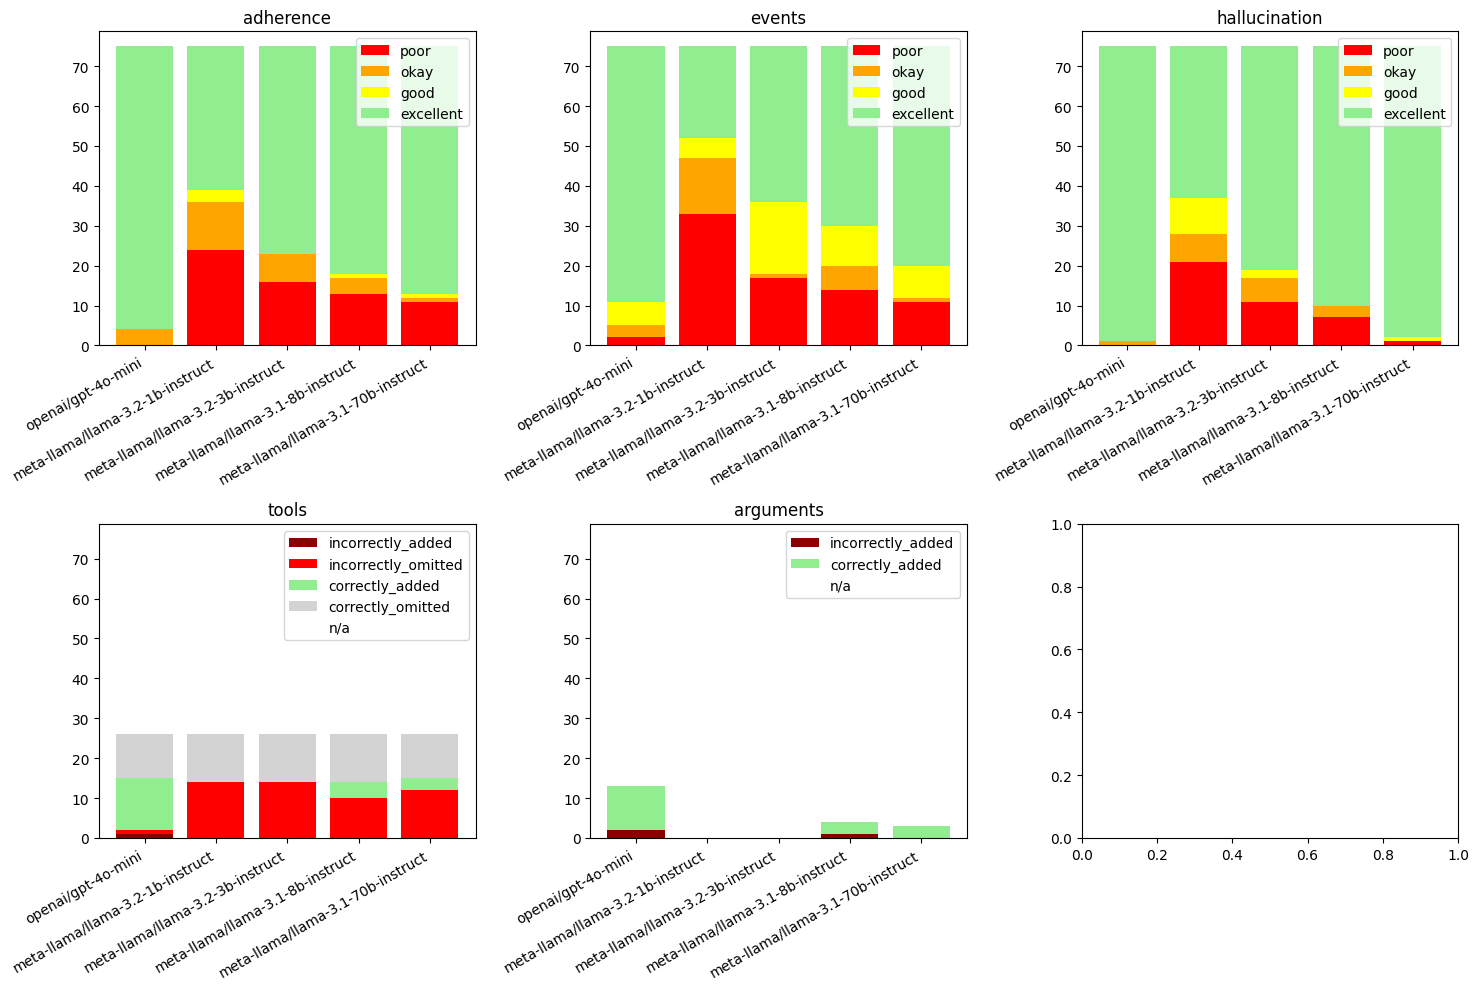

In [7]:
import numpy as np

import matplotlib.pyplot as plt

criteria = ['adherence', 'events', 'hallucination', 'tools', 'arguments']
labels = ['poor', 'okay', 'good', 'excellent', 'incorrectly_added', 'incorrectly_omitted', 'correctly_added', 'correctly_omitted', 'n/a']
colors = {
    'poor': 'red',
    'okay': 'orange',
    'good': 'yellow',
    'excellent': 'lightgreen',
    'correctly_added': 'lightgreen',
    'correctly_omitted': 'lightgrey',
    'incorrectly_added': 'darkred',
    'incorrectly_omitted': 'red',
    'n/a': 'white',
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, criterion in enumerate(criteria):
    ax = axs[i]
    models = list(stats.keys())
    scores = {label: [stats[model][criterion].get(label, 0) for model in models] for label in labels if label in stats[models[0]][criterion]}
    
    bottom = np.zeros(len(models))
    for j, label in enumerate(scores.keys()):
        ax.bar(models, scores[label], bottom=bottom, label=label, color=colors[label])
        bottom += np.array(scores[label])
    
    ax.set_title(criterion)
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()